In [1]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models

In [2]:
transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
class FoodDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path)

        label = int(img_name.split('_')[0])

        if self.transform:
            image = self.transform(image)

        return image, label



In [4]:
train_dataset = FoodDataset("dataset/training", transform=transforms)
val_dataset = FoodDataset("dataset/validation", transform=transforms)
test_dataset = FoodDataset("dataset/evaluation", transform=transforms)

batch_size = 128

print(f"Number of CPU cores: {os.cpu_count()}")
cores = os.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=cores)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=cores)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=cores)

print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Number of CPU cores: 96
Training set: 9866 images
Validation set: 3430 images
Test set: 3347 images


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)

        self.pool = nn.MaxPool2d(2, 2, 0)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 32 * 32)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [6]:
class VGGCustom(nn.Module):
    def __init__(self, num_classes):
        super(VGGCustom, self).__init__()

        self.vgg = models.vgg16(weights='DEFAULT')

        self.vgg.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.vgg(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}, Name: {torch.cuda.get_device_name(0)}")

#model = SimpleCNN(num_classes=11).to(device)
model = VGGCustom(num_classes=11).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

epochs = 30

scaler = torch.cuda.amp.GradScaler()

Using device: cuda, Name: Tesla V100-SXM3-32GB


In [14]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.2f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
    
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                
    accuracy = (correct / total) * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Validation Loss: {val_loss / len(val_loader):.2f}, Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Epoch [1/30], Loss: 1.54
Validation Loss: 0.74, Accuracy: 76.56%
Precision: 0.77, Recall: 0.77, F1 Score: 0.76
Epoch [2/30], Loss: 0.69
Validation Loss: 0.54, Accuracy: 82.59%
Precision: 0.83, Recall: 0.83, F1 Score: 0.83
Epoch [3/30], Loss: 0.50
Validation Loss: 0.47, Accuracy: 84.49%
Precision: 0.85, Recall: 0.84, F1 Score: 0.84
Epoch [4/30], Loss: 0.38
Validation Loss: 0.44, Accuracy: 86.06%
Precision: 0.86, Recall: 0.86, F1 Score: 0.86
Epoch [5/30], Loss: 0.32
Validation Loss: 0.40, Accuracy: 86.91%
Precision: 0.87, Recall: 0.87, F1 Score: 0.87
Epoch [6/30], Loss: 0.27
Validation Loss: 0.40, Accuracy: 87.78%
Precision: 0.88, Recall: 0.88, F1 Score: 0.88
Epoch [7/30], Loss: 0.21
Validation Loss: 0.38, Accuracy: 88.13%
Precision: 0.88, Recall: 0.88, F1 Score: 0.88
Epoch [8/30], Loss: 0.17
Validation Loss: 0.38, Accuracy: 88.28%
Precision: 0.88, Recall: 0.88, F1 Score: 0.88
Epoch [9/30], Loss: 0.14
Validation Loss: 0.40, Accuracy: 88.22%
Precision: 0.89, Recall: 0.88, F1 Score: 0.88
E

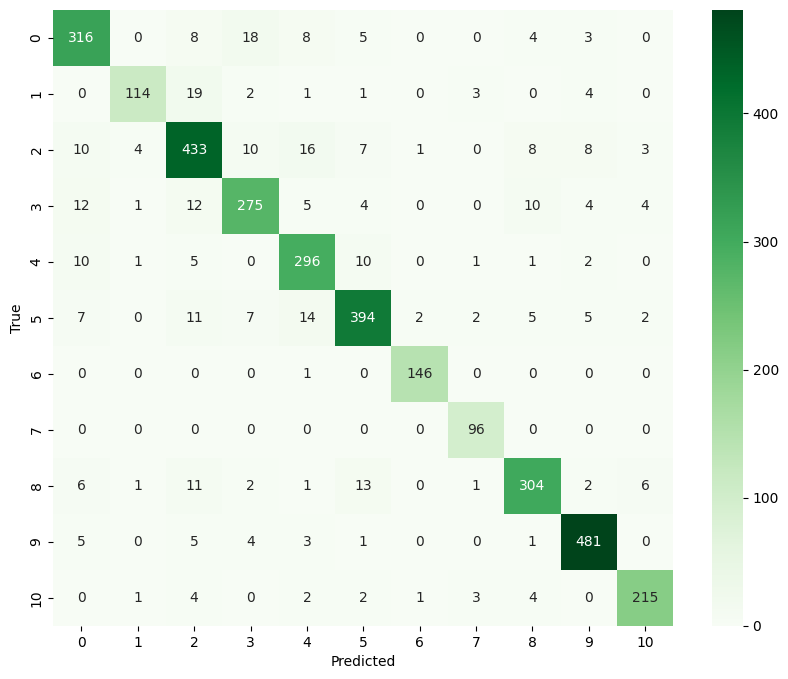

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()